In [117]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [118]:
SMALL_SIZE = 10
MEDIUM_SIZE = 25
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 2.)

load data

In [152]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/hcp/")
hcp_data_dict = np.load(data_dir/"hcp_data_dict.npy", allow_pickle=True).item()
brain_networks = hcp_data_dict["network"] / count_offset
traits = hcp_data_dict["cog"]
avg_trans = np.nanmean(hcp_data_dict["trans"], -1)
avg_rotat = np.nanmean(hcp_data_dict["rotat"], -1)

print(brain_networks.shape)
print(traits.shape)
print(avg_trans.shape)

(1061, 68, 68)
(1061, 175)
(1061,)


In [153]:
motion = np.c_[avg_trans, avg_rotat]

In [154]:
pic_vocab = traits[:,6]
card_sort = traits[:,42]
oral_reading = traits[:,4]
pattern_complete = traits[:,10]
pic_seq = traits[:,37]

In [155]:
drop_ids = np.isnan(card_sort)
card_sort = card_sort[~drop_ids]
brain_networks = brain_networks[~drop_ids]
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [156]:
# card_sort = card_sort[~drop_ids]
lr = LinearRegression().fit(motion, card_sort)
yhat = lr.predict(motion)
card_sort = card_sort - yhat

In [157]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = 1., add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=500, lr=1e-5, device=DEVICE)

In [158]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [159]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(card_sort).to(torch.float32) 

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

953 106


vae

In [160]:
card_sort_vae = VAE(config).to(config.device)
card_sort_vae.apply(reset_weights)
card_sort_vae.set_mask(knn_masks)
optimizer = optim.Adam(card_sort_vae.parameters(), lr=config.lr) 

In [161]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = card_sort_vae.reg_train(epoch, train_loader, card_sort_vae, optimizer, config.device, n_epoch_display=5)
    val_loss = card_sort_vae.reg_test(epoch, val_loader, card_sort_vae, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: -722.559 nll: -924.078 kl: 104.464 rmse: 1.739
epoch: 0 test loss: -6671.184 nll: -6809.707 kl: 42.908 rmse: 1.858
epoch: 5 train loss: -16820.764 nll: -16929.248 kl: 12.614 rmse: 1.729
epoch: 5 test loss: -16484.194 nll: -16592.188 kl: 12.816 rmse: 1.854
epoch: 10 train loss: -16884.609 nll: -16990.370 kl: 11.111 rmse: 1.718
epoch: 10 test loss: -16536.729 nll: -16643.260 kl: 11.460 rmse: 1.852
epoch: 15 train loss: -16903.250 nll: -17007.152 kl: 10.565 rmse: 1.706
epoch: 15 test loss: -16554.091 nll: -16660.007 kl: 10.945 rmse: 1.851
epoch: 20 train loss: -16912.884 nll: -17015.537 kl: 10.730 rmse: 1.693
epoch: 20 test loss: -16560.795 nll: -16666.710 kl: 11.129 rmse: 1.849
epoch: 25 train loss: -16920.979 nll: -17022.826 kl: 11.547 rmse: 1.678
epoch: 25 test loss: -16567.220 nll: -16673.725 kl: 11.876 rmse: 1.846
epoch: 30 train loss: -16928.879 nll: -17030.281 kl: 12.929 rmse: 1.660
epoch: 30 test loss: -16575.338 nll: -16683.007 kl: 13.019 rmse: 1.846
epoch: 3

inv_vae

In [166]:
# config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
#     n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
#     beta = .01, gamma = 0., add_reg = True, y_dim = 1,
#     batch_size=32, n_epochs=1000, lr=1e-5, device=DEVICE)

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
    beta = .0001, gamma = 0., add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [167]:
card_sort_inv = INV_VAE(config).to(config.device)
card_sort_inv.apply(reset_weights)
card_sort_inv.set_mask(knn_masks)
optimizer = optim.Adam(card_sort_inv.parameters(), lr=config.lr) 

In [168]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = card_sort_inv.reg_train(epoch, train_loader, card_sort_inv, optimizer, config.device, n_epoch_display=5)
    val_loss = card_sort_inv.reg_test(epoch, val_loader, card_sort_inv, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 98.106 nll: 5822.506 kl: 190.603 inv_loss: 2.376 rmse: 1.748
epoch: 0 test loss 95.288 nll: 5815.940 kl: 170.835 inv_loss: 2.166 rmse: 1.851
epoch: 5 train loss: 93.767 nll: 5824.114 kl: 190.872 inv_loss: 0.806 rmse: 1.709
epoch: 5 test loss 94.881 nll: 5816.871 kl: 190.127 inv_loss: 0.892 rmse: 1.848
epoch: 10 train loss: 90.711 nll: 5823.973 kl: 236.904 inv_loss: 0.592 rmse: 1.681
epoch: 10 test loss 94.602 nll: 5818.370 kl: 234.380 inv_loss: 0.684 rmse: 1.844
epoch: 15 train loss: 87.581 nll: 5823.789 kl: 281.651 inv_loss: 0.510 rmse: 1.651
epoch: 15 test loss 94.390 nll: 5816.573 kl: 277.766 inv_loss: 0.602 rmse: 1.840
epoch: 20 train loss: 84.116 nll: 5823.291 kl: 329.059 inv_loss: 0.465 rmse: 1.618
epoch: 20 test loss 94.425 nll: 5814.804 kl: 324.415 inv_loss: 0.558 rmse: 1.839
epoch: 25 train loss: 80.239 nll: 5823.332 kl: 383.901 inv_loss: 0.435 rmse: 1.581
epoch: 25 test loss 94.641 nll: 5815.203 kl: 379.796 inv_loss: 0.531 rmse: 1.839
epoch: 30 train loss

In [175]:
# np.save("../saved_res/card_sort_vae_pcs.npy", card_sort_vae_pcs)
# np.save("../saved_res/card_sort_inv_pcs.npy", card_sort_inv_pcs)

plotting

In [169]:
n=39
x = 0.32 
cmap = plt.cm.jet
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

/tmp/ipykernel_111470/2561100898.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


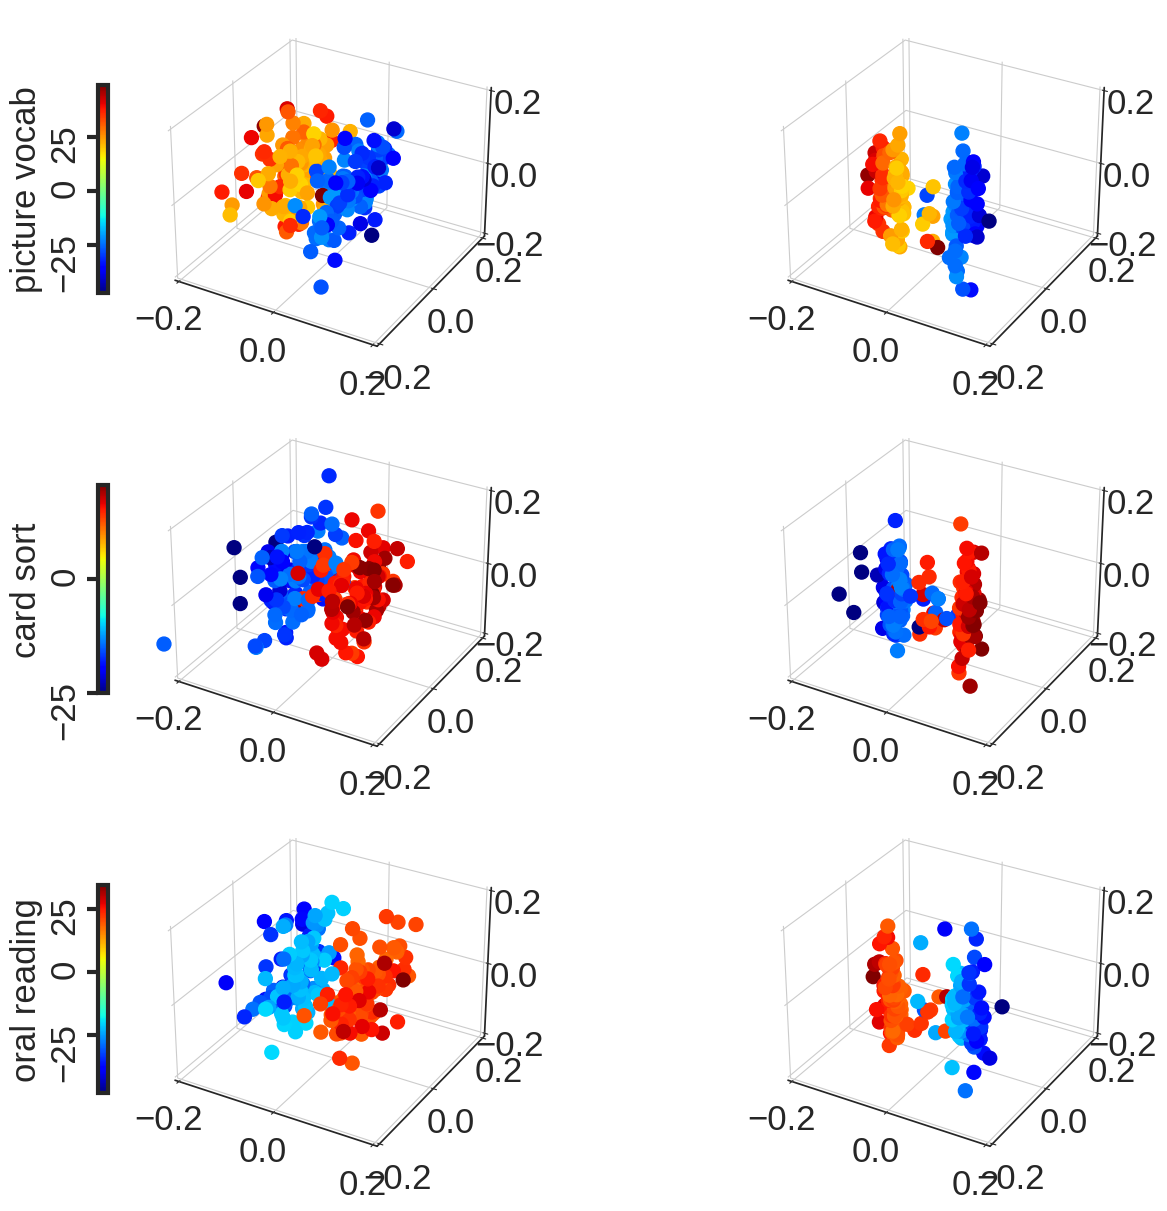

In [174]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True, subplot_kw=dict(projection='3d'))
plt.style.use('seaborn-white')

################## pic vocab - vae ##################
# pic_vocab_vae_z_mean, _ = pic_vocab_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_vae_y_pred, _, _ = pic_vocab_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# pic_vocab_vae_z_mean = pic_vocab_vae_z_mean.detach().cpu().numpy()
# pic_vocab_vae_y_pred = pic_vocab_vae_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_vae_z_mean_sub = pic_vocab_vae_z_mean[pic_vocab_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_vae_z_mean_sub.transpose())
# pic_vocab_vae_pcs = pca.components_.transpose()

p1 = axes[0,0].scatter(pic_vocab_vae_pcs[:,0], pic_vocab_vae_pcs[:,1], pic_vocab_vae_pcs[:,2], c=pic_vocab_vae_colors, 
                       cmap = 'jet', s = 100, alpha=1.)
cb = fig.colorbar(p1, ax=axes[0,0], location='left', fraction=0.02, label='picture vocab')
# axes[0,0].set_xlim3d(min(pic_vocab_vae_pcs[:,0]), max(pic_vocab_vae_pcs[:,0]))
# axes[0,0].set_ylim3d(min(pic_vocab_vae_pcs[:,1]), max(pic_vocab_vae_pcs[:,1]))
# axes[0,0].set_zlim3d(min(pic_vocab_vae_pcs[:,2]), max(pic_vocab_vae_pcs[:,2]))
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)
axes[0,0].set_xlim3d(-0.2, 0.2)
axes[0,0].set_ylim3d(-0.2, 0.2)
axes[0,0].set_zlim3d(-0.2, 0.2)

################## pic vocab - inv_vae ##################
# pic_vocab_inv_z_mean, _ = pic_vocab_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_inv_y_pred, _, _ = pic_vocab_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# pic_vocab_inv_z_mean = pic_vocab_inv_z_mean.detach().cpu().numpy()
# pic_vocab_inv_y_pred = pic_vocab_inv_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_inv_z_mean_sub = pic_vocab_inv_z_mean[pic_vocab_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_inv_z_mean_sub.transpose())
# pic_vocab_inv_pcs = pca.components_.transpose()

p2 = axes[0,1].scatter(pic_vocab_inv_pcs[:,0], pic_vocab_inv_pcs[:,1], pic_vocab_inv_pcs[:,2], 
                       c=pic_vocab_vae_colors, cmap = 'jet', s = 100, alpha=1.)
# axes[0,1].set_title('inv-VAE')
# axes[0,1].set_xlim3d(min(pic_vocab_inv_pcs[:,0]), max(pic_vocab_inv_pcs[:,0]))
# axes[0,1].set_ylim3d(min(pic_vocab_inv_pcs[:,1]), max(pic_vocab_inv_pcs[:,1]))
# axes[0,1].set_zlim3d(min(pic_vocab_inv_pcs[:,2]), max(pic_vocab_inv_pcs[:,2]))
axes[0,1].set_xlim3d(-0.2, 0.2)
axes[0,1].set_ylim3d(-0.2, 0.2)
axes[0,1].set_zlim3d(-0.2, 0.2)

################## card sort - vae ##################
# card_sort_vae_z_mean, _ = card_sort_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_vae_y_pred, _, _ = card_sort_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# card_sort_vae_z_mean = card_sort_vae_z_mean.detach().cpu().numpy()
# card_sort_vae_y_pred = card_sort_vae_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_vae_z_mean_sub = card_sort_vae_z_mean[card_sort_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(card_sort_vae_z_mean_sub.transpose())
# card_sort_vae_pcs = pca.components_.transpose()

p3 = axes[1,0].scatter(card_sort_vae_pcs[:,0], card_sort_vae_pcs[:,1], card_sort_vae_pcs[:,2], 
                       c=card_sort_vae_colors, cmap = 'jet', s = 100, alpha=1., vmin=-25)
cb = fig.colorbar(p3, ax=axes[1,0], location='left', fraction=0.02, label='card sort')
axes[1,0].set_xlim3d(min(card_sort_vae_pcs[:,0]), max(card_sort_vae_pcs[:,0]))
axes[1,0].set_ylim3d(min(card_sort_vae_pcs[:,1]), max(card_sort_vae_pcs[:,1]))
axes[1,0].set_zlim3d(min(card_sort_vae_pcs[:,2]), max(card_sort_vae_pcs[:,2]))
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)
axes[1,0].set_xlim3d(-0.2, 0.2)
axes[1,0].set_ylim3d(-0.2, 0.2)
axes[1,0].set_zlim3d(-0.2, 0.2)

################## card sort - inv_vae ##################
card_sort_inv_z_mean, _ = card_sort_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, card_sort_inv_y_pred, _, _ = card_sort_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
card_sort_inv_z_mean = card_sort_inv_z_mean.detach().cpu().numpy()
card_sort_inv_y_pred = card_sort_inv_y_pred.detach().cpu().numpy()

card_sort_y_ids = np.argsort(card_sort)
card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

card_sort_inv_z_mean_sub = card_sort_inv_z_mean[card_sort_y_sub_ids, :]
pca = PCA(n_components=3)
pca.fit(card_sort_inv_z_mean_sub.transpose())
card_sort_inv_pcs = pca.components_.transpose()

p4 = axes[1,1].scatter(card_sort_inv_pcs[:,0], card_sort_inv_pcs[:,1], card_sort_inv_pcs[:,2], c=card_sort_vae_colors, 
                       cmap = 'jet', s = 100, alpha=1., vmin=-25)
axes[1,1].set_xlim3d(min(card_sort_inv_pcs[:,0]), max(card_sort_inv_pcs[:,0]))
axes[1,1].set_ylim3d(min(card_sort_inv_pcs[:,1]), max(card_sort_inv_pcs[:,1]))
axes[1,1].set_zlim3d(min(card_sort_inv_pcs[:,2]), max(card_sort_inv_pcs[:,2]))
axes[1,1].set_xlim3d(-0.2, 0.2)
axes[1,1].set_ylim3d(-0.2, 0.2)
axes[1,1].set_zlim3d(-0.2, 0.2)

################## oral reading - vae ##################
# oral_reading_vae_z_mean, _ = oral_reading_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, oral_reading_vae_y_pred, _, _ = oral_reading_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# oral_reading_vae_z_mean = oral_reading_vae_z_mean.detach().cpu().numpy()
# oral_reading_vae_y_pred = oral_reading_vae_y_pred.detach().cpu().numpy()

# oral_reading_y_ids = np.argsort(oral_reading)
# oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

# oral_reading_vae_z_mean_sub = oral_reading_vae_z_mean[oral_reading_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(oral_reading_vae_z_mean_sub.transpose())
# oral_reading_vae_pcs = pca.components_.transpose()

p5 = axes[2,0].scatter(oral_reading_vae_pcs[:,0], oral_reading_vae_pcs[:,1], oral_reading_vae_pcs[:,2], 
                       c=oral_reading_vae_colors, cmap = 'jet', s = 100, alpha=1.)
cb = plt.colorbar(p5, ax=axes[2,0], location='left', fraction=0.02, label='oral reading')
# axes[2,0].set_xlim3d(min(oral_reading_vae_pcs[:,0]), max(oral_reading_vae_pcs[:,0]))
# axes[2,0].set_ylim3d(min(oral_reading_vae_pcs[:,1]), max(oral_reading_vae_pcs[:,1]))
# axes[2,0].set_zlim3d(min(oral_reading_vae_pcs[:,2]), max(oral_reading_vae_pcs[:,2]))
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)
axes[2,0].set_xlim3d(-0.2, 0.2)
axes[2,0].set_ylim3d(-0.2, 0.2)
axes[2,0].set_zlim3d(-0.2, 0.2)


################## oral reading - inv_vae ##################
# oral_reading_inv_z_mean, _ = oral_reading_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, oral_reading_inv_y_pred, _, _ = oral_reading_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# oral_reading_inv_z_mean = oral_reading_inv_z_mean.detach().cpu().numpy()
# oral_reading_inv_y_pred = oral_reading_inv_y_pred.detach().cpu().numpy()

# oral_reading_y_ids = np.argsort(oral_reading)
# oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

# oral_reading_inv_z_mean_sub = oral_reading_inv_z_mean[oral_reading_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(oral_reading_inv_z_mean_sub.transpose())
# oral_reading_inv_pcs = pca.components_.transpose()

p6 = axes[2,1].scatter(oral_reading_inv_pcs[:,0], oral_reading_inv_pcs[:,1], oral_reading_inv_pcs[:,2], 
                       c=oral_reading_vae_colors, cmap = 'jet', s = 100, alpha=1.)
# axes[2,1].set_xlim3d(min(oral_reading_inv_pcs[:,0]), max(oral_reading_inv_pcs[:,0]))
# axes[2,1].set_ylim3d(min(oral_reading_inv_pcs[:,1]), max(oral_reading_inv_pcs[:,1]))
# axes[2,1].set_zlim3d(min(oral_reading_inv_pcs[:,2]), max(oral_reading_inv_pcs[:,2]))
axes[2,1].set_xlim3d(-0.2, 0.2)
axes[2,1].set_ylim3d(-0.2, 0.2)
axes[2,1].set_zlim3d(-0.2, 0.2)

for i in range(3):
    for j in range(2):
        axes[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        

plt.savefig('../saved_figs/fig8_hcp_trait_latents.png', facecolor='white', dpi=800)
plt.show()